In [32]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pymongo import MongoClient
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from ajna_commons.flask.conf import DATABASE, MONGODB_URI
from ajna_commons.utils.images import generate_batch, get_imagens_recortadas

db = MongoClient(host=MONGODB_URI)[DATABASE]

In [33]:
filtro = {
    'metadata.contentType': 'image/jpeg',
    'metadata.predictions.bbox': {'$exists': True, '$ne': None},
    'metadata.carga.vazio': False
}
projection = ['metadata.carga.container', 'metadata.carga.container']

In [34]:
batch_gen = generate_batch(db, filtro=filtro, projection=projection, batch_size=4, limit=4)

In [35]:
batch, rows = next(batch_gen)

In [36]:
def extrai_pesos(lista):
    pesos = []
    for linha in lista:
        carga = linha.get('metadata').get('carga')
        if carga:
            container = carga.get('container')
            if container:
                tara = float(container[0].get('taracontainer').replace(',', '.'))
                peso = float(container[0].get('pesobrutoitem').replace(',', '.'))
                pesos.append(tara + peso)
    return pesos

pesos = extrai_pesos(rows)
print(len(rows), pesos)

4 [25940.0, 10996.288, 7762.1, 22312.0]


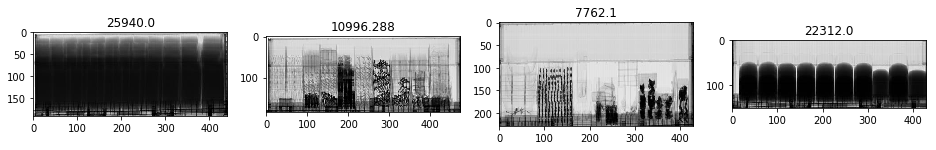

In [37]:
%matplotlib inline
def plot_pesos(images, rows):
    ncolumns = 4
    nrows = len(rows) // ncolumns
    fig=plt.figure(figsize=(16, 4 * nrows))
    for i, (image, row) in enumerate(zip(images, rows)):
        ax = fig.add_subplot(nrows, ncolumns, i + 1)
        ax.set(title=str(pesos[i]))
        plt.imshow(image[0])
    plt.show()
plot_pesos(batch, rows)

# Para treinar, vamos extrair histogramas e colocá-los no "X" e colocar os pesos no y. Para não ter que carregar milhares de imagens na memória, vamos puxar em batches

In [57]:
batch_gen = generate_batch(db, filtro=filtro, batch_size=100, limit=100)
X = []
y = []
NBINS = 16
for images, rows in batch_gen:
    if not images:
        break
    for image, row in zip(images, rows):
        hist = np.histogram(image[0], bins=NBINS)
        pesos = extrai_pesos([row])
        if pesos and len(pesos) == 1:
            X.append(hist[0].tolist())
            y.append(pesos[0])
            sys.stdout.write('\r'+str(len(y)))
    

1000

In [59]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)
reg = RandomForestRegressor()
reg.fit(Xtrain, ytrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [60]:
ypred = reg.predict(Xtest)

In [65]:
error = mean_absolute_error(ytest, ypred)
mean = float(sum(y) / len(y))
print(error, mean)

1670.254344 19452.67015699999


In [66]:
print('Erro médio absoluto {:.2f} / {:.0%}'.format(error, error / mean))

Erro médio absoluto 1670.25 / 9%


## Agora basta salvar o modelo em um pipeline (que faça o histograma)

In [90]:
from sklearn.pipeline import Pipeline

class Histogram():
    def fit(self, _):
        return self
    def transform(self, img_array):
        return [np.histogram(img_array, bins=NBINS)[0].tolist()]
    

new_padma_model = Pipeline([
    ('histogram', Histogram()),
    ('regressor', reg)
])

In [91]:
new_padma_model.predict(np.array(image[0]))

array([9807.998])

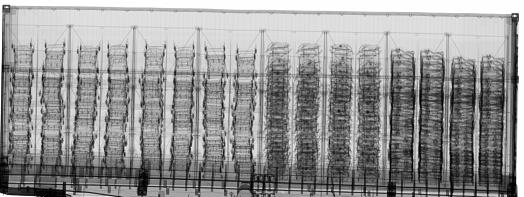

In [92]:
image[0]

## Usar joblib para salvar modelo e fazer upload para PADMA


## Consultar padma